In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split# We plot a histogram of a variable with 100 bins.
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
# Import data.
loan_data_defaults = pd.read_csv('loan_data_defaults.csv')

/var/folders/2h/rjm2fb_j53gb0nswwgx_xyfc0000gn/T/ipykernel_56532/1972329785.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_defaults = pd.read_csv('loan_data_defaults.csv')


In [8]:
current_date = pd.to_datetime('2017-12-01')
loan_data_defaults['issue_d_dates'] = pd.to_datetime(loan_data_defaults['issue_d'], format = '%b-%y')
loan_data_defaults = loan_data_defaults.rename(columns={'months_since_earliest_cr_line': 'mths_since_earliest_cr_line'})
loan_data_defaults['mths_since_issue_d'] = (current_date - loan_data_defaults['issue_d_dates']).apply(lambda x: x.days // 30)

In [10]:
# o means bad/default and 1 means good/non-default
loan_data_defaults['good_bad'] = np.where(
    loan_data_defaults['loan_status'].isin(
        ['Charged Off','Default','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']),
        0,1)

In [11]:
# EAD model datasets
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [12]:
ead_inputs_train.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [14]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [16]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [24]:
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1,positive = False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [15]:
ead_inputs_train = ead_inputs_train[features_all]


In [17]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)


In [26]:
ead_inputs_train = ead_inputs_train.astype(float)

In [27]:
reg_ead = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

In [28]:
feature_name = ead_inputs_train.columns.values

In [45]:
import pickle 
pickle.dump(reg_ead, open('ead_model.sav', 'wb'))


In [30]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_ead.p
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.110796e+00,NaN
1,grade:A,-3.054891e-01,0.000000e+00
2,grade:B,-2.385226e-01,0.000000e+00
3,grade:C,-1.736382e-01,0.000000e+00
4,grade:D,-1.209466e-01,0.000000e+00
5,grade:E,-6.828982e-02,0.000000e+00
6,grade:F,-2.069374e-02,4.013558e-03
7,home_ownership:MORTGAGE,-6.420891e-03,2.336240e-03
8,home_ownership:NONE,-6.685160e-03,9.178637e-01
9,home_ownership:OTHER,-3.324488e-03,9.090946e-01


# Model Validation

In [31]:
ead_inputs_test = ead_inputs_test[features_all]


In [32]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)


In [33]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [34]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)


In [36]:
ead_targets_test_temp = ead_targets_test

In [37]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)


In [39]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()


,CCF,0
CCF,1.000000,0.530462
0,0.530462,1.000000


/var/folders/2h/rjm2fb_j53gb0nswwgx_xyfc0000gn/T/ipykernel_56532/1012672244.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_targets_test - y_hat_test_ead)


<Axes: xlabel='CCF', ylabel='Density'>

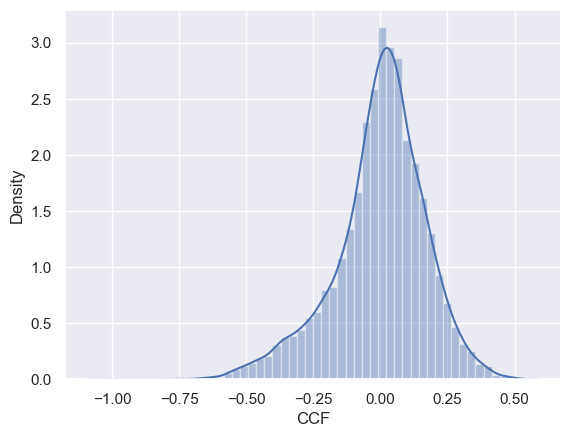

In [40]:
sns.distplot(ead_targets_test - y_hat_test_ead)


In [41]:
pd.DataFrame(y_hat_test_ead).describe()


,0
count,8648.000000
mean,0.736008
std,0.105142
min,0.387418
25%,0.661766
50%,0.731701
75%,0.810676
max,1.153989


In [42]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [43]:
pd.DataFrame(y_hat_test_ead).describe()


,0
count,8648.000000
mean,0.735988
std,0.105079
min,0.387418
25%,0.661766
50%,0.731701
75%,0.810676
max,1.000000
